In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import fnmatch
import os
from matplotlib import colors
import matplotlib.pyplot as plt

2021-12-13 17:48:00.704219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 17:48:00.704234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%run data_collection.ipynb

In [3]:
prod_model = keras.models.load_model('model_weights/epic_num_reader.model')

2021-12-13 17:48:45.395733: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-13 17:48:45.395783: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coco): /proc/driver/nvidia/version does not exist
2021-12-13 17:48:45.396257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
initialize(3,0.3)
final_grid = encode_grid(grid,[])
final_grid[0,0] = 4

In [7]:
prod_model.predict(np.asarray([final_grid.tolist()]))

array([[1.1993588e-31, 6.6780504e-03, 3.4988502e-14, 9.9332196e-01]],
      dtype=float32)

In [112]:
initialize(10,0.2)

In [64]:
def patch_of_grid(grid,current_position):
    global maze_size
    mat =  grid.copy()
    row = current_position[0]
    col = current_position[1]
    
    col_left = col- 1
    col_right = col + 1
    
    row_high = row - 1
    row_low = row + 1
    
    # print("initial cols:",col_left,col_right,"rows: ",row_high,row_low)
    if(col_left<0): # workng
        difference = 0-col_left
        col_left = 0 
        col_right += difference
        
    if(col_right>maze_size-1):
        difference = col_right - maze_size + 1
        col_left -= difference
        col_right = maze_size - 1
        
    if(row_low>maze_size-1):
        difference = row_low - maze_size + 1
#         print(difference)
        row_low = maze_size - 1 
        row_high -= difference
    if(row_high<0):
        difference = 0-row_high
        row_high = 0
        row_low += difference
    
    return row-row_high,col-col_left, mat[row_high:row_low+1,col_left:col_right+1]

In [68]:
row, col, mat = patch_of_grid(grid,(9,0))

In [100]:
grid

matrix([[0, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 0]])

In [70]:
row, col, mat

(2,
 0,
 matrix([[0, 0, 0],
         [1, 1, 1],
         [1, 0, 1]]))

In [106]:
def run_ml_1_agent_2(model,grid):
    global maze_size
    
    visited = []
    goal_reached = False
    goal = (maze_size-1,maze_size-1)
    counter = 0
    agent_grid = np.asmatrix(np.zeros(maze_size*maze_size, dtype=int).reshape(maze_size,maze_size))
    directions_dict = {0:"Up",1:"Down",2:"Left",3:"Right"}
    
    current_position = (0,0)
    while not goal_reached and counter!=50:
        print("initial current position: ",current_position)
        
        if current_position not in visited:
            visited.append(current_position)
            
        # check if current_position ia the goal
        if(current_position==goal):
            print("goal reached")
            return True
         
        #else get direction
        patch = encode_grid(agent_grid,visited)
        row,col,patch = patch_of_grid(patch,current_position)
        print("currentposition: ",row,col,"\npredicting for: \n",patch)
#         patch = encode_grid(patch,visited)
        patch[row,col] = 4
#         print("encoded: ",patch)
        direction = model.predict(np.asarray([patch.tolist()]))[0]
#         print(direction)
        direction = np.argmax(direction)
        print(directions_dict[direction])
        
        #update coordinates according to direction
        row = current_position[0]
        col = current_position[1]
        if(direction == 0 and row-1>=0): #Up
            row -= 1
        elif(direction == 1 and row+1<maze_size): #down
            row += 1
        elif(direction == 2 and col-1>=0): #left
            col -=1
        elif(col+1<maze_size): #right
            col +=1
            
        # check if new current position. if yes, update agent_grid
        # and don't update current position
        if(grid[row,col]==1):
#             print(row,col)
            agent_grid[row,col]=1
            print("hit block, agent_grid now:\n",agent_grid)
            counter += 1
            continue
        #else update current position
        current_position = (row,col)
        
        print("final current_position: ",current_position,"\n------------------------------\n")
        counter += 1
    return False
    

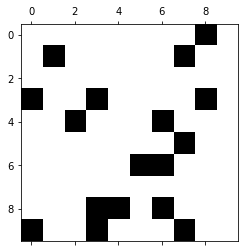

In [113]:
plt.spy(grid)

In [114]:
run_ml_1_agent_2(prod_model,grid)

initial current position:  (0, 0)
currentposition:  0 0 
predicting for: 
 [[1 3 3]
 [3 3 3]
 [3 3 3]]
Down
final current_position:  (1, 0) 
------------------------------

initial current position:  (1, 0)
currentposition:  1 0 
predicting for: 
 [[1 3 3]
 [1 3 3]
 [3 3 3]]
Down
final current_position:  (2, 0) 
------------------------------

initial current position:  (2, 0)
currentposition:  1 0 
predicting for: 
 [[1 3 3]
 [1 3 3]
 [3 3 3]]
Down
hit block, agent_grid now:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
initial current position:  (2, 0)
currentposition:  1 0 
predicting for: 
 [[1 3 3]
 [1 3 3]
 [2 3 3]]
Right
final current_position:  (2, 1) 
------------------------------

initial current position:  (2, 1)
currentposition:  1 1 
predicting for: 
 [[1 3 3]
 [1 1 3]
 [2 3 3]]
Down
final

True